## Variational inference in Dirichlet Process Normal Mixture

In [1]:
import autograd
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp
import DP_normal_mixture_opt_lib as dp_opt
import DP_lrvb as lrvb

from copy import deepcopy

from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [2]:
np.random.seed(52432)
# np.random.seed(54325)

# data parameters
num_obs = 1000 # number of observations 
x_dim = 2 # dimension of observations
k_true = 5 # true number of clusters

info_x = 0.1 * np.eye(x_dim) 

x, true_mu, true_z, true_pi = dp.draw_data(info_x, x_dim, k_true, num_obs)


# prior parameters
alpha = 2.0 # DP parameter
prior_mu = np.mean(x, axis = 0)
prior_info = 0.1 * np.eye(x_dim)

# variational truncation 
k_approx = 10 



observed mixture proportions: 
 [ 0.214  0.203  0.181  0.214  0.188]
true mixture proportions: 
 [ 0.2  0.2  0.2  0.2  0.2]


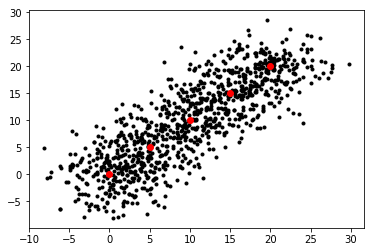

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

# Set up VB model

In [4]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [5]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))
prior_params.push_param(PosDefMatrixParam(name='prior_info', size=x_dim, val=prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

In [6]:
model = dp.DPNormalMixture(x, vb_params, prior_params)

# Initialize

In [7]:
## initialize VB params

true_init = False

if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    vb_params['global']['v_sticks'].alpha.set(true_tau)

    # vb_params['global']['mu'].set(true_mu)
    mu_size = vb_params['global']['mu'].free_size()
    vb_params['global']['mu'].set_free(np.random.random(mu_size))
    
    true_z_fudged = dp.soft_thresh(true_z, 1 - 10**(-8), 10**(-8))
    vb_params['local']['e_z'].set(true_z_fudged)
    # z_size = vb_params['local']['e_z'].free_size()
    # vb_params['local']['e_z'].set_free(np.random.random(z_size))
else: 
    vb_params.set_free(np.random.random(vb_params.free_size()))
    
init_free_params = vb_params.get_free()
global_init_free_params = vb_params['global'].get_free()

# Run CAVI 

CAVI terminated successfully :)
iterations ran:  285
elbo:  -13633.6368972


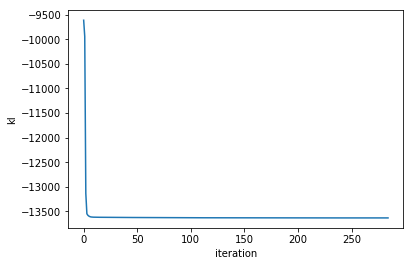

In [8]:
dp_opt.run_cavi(model, init_free_params, max_iter = 1000, tol = 1e-5, disp = False)
cavi_results = deepcopy(model)
print('elbo: ', cavi_results.get_kl())


### examine results of CAVI

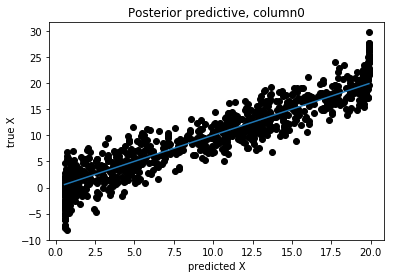

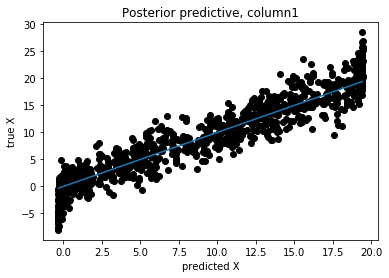

In [9]:
# plot posterior predictive
e_z = cavi_results.vb_params['local']['e_z'].get()
mu = cavi_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [10]:
# lets look at the estimated mixture proportions

tau = cavi_results.vb_params['global']['v_sticks'].alpha.get() 
post_stick_length = tau[:,0] / np.sum(tau, axis = 1) # mean posterior stick lengths

# compute mixture proportions using mean posterior stick lengths
post_pi = np.ones(k_approx)
stick_remain = np.ones(k_approx - 1)
for i in range(k_approx - 1):
    post_pi[i] = stick_remain[i - 1] * post_stick_length[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - post_stick_length[i])
post_pi[-1] = stick_remain[-1]
assert(np.abs(np.sum(post_pi) - 1.) < 10**(-10))

print('true_proportions', true_pi)
print('estimated proportions: ', post_pi, '\n')

heavy_clusters = post_pi > 1 / k_approx # clusters with significant weights 

print('true number of clusters: ', k_true)
print('number of "posterior clusters" (ie. no. clusters w/ siginifcant weights): ', np.sum(post_pi > 1 / k_approx))
print('recall variational truncation: ', k_approx)

true_proportions [ 0.2  0.2  0.2  0.2  0.2]
estimated proportions:  [ 0.00163527  0.16729781  0.19866434  0.0016189   0.0016122   0.21662117
  0.00159565  0.22253406  0.00156521  0.18685538] 

true number of clusters:  5
number of "posterior clusters" (ie. no. clusters w/ siginifcant weights):  5
recall variational truncation:  10


In [11]:
# lets look at posterior means
print('true means: ')
print(true_mu, '\n')

print('relevant posterior means (ie. posterior means for clusters with significant weights): ')
post_mean = cavi_results.vb_params['global']['mu'].get()[heavy_clusters, :]
print(post_mean)

true means: 
[[ 0  0]
 [ 5  5]
 [10 10]
 [15 15]
 [20 20]] 

relevant posterior means (ie. posterior means for clusters with significant weights): 
[[ 10.33477486  10.22472846]
 [  4.823199     5.23114756]
 [ 19.88550546  19.44574591]
 [  0.56729952  -0.34197799]
 [ 14.25093618  14.71048693]]


here, black are data points. red are the true means. blue are the posterior means


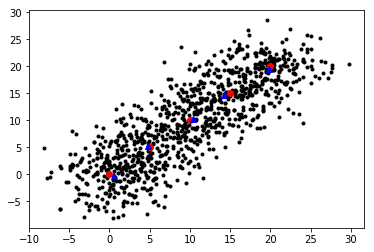

In [12]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')

print('here, black are data points. red are the true means. blue are the posterior means')

# Newton Optimization

In [13]:
kl_obj = Objective(model.vb_params['global'], model.kl_optimize_z)

In [14]:
def minimize_kl(kl_obj, init_x, maxiter = 50, gtol = 1e-6, disp = True):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hessp=kl_obj.fun_free_hvp,
        method='trust-ncg', options={'maxiter': maxiter, 'gtol': gtol, 'disp': disp})

    print('done :o')
    return vb_opt

newton_tr_init = cavi_results.vb_params['global'].get_free() # initialize with result from CAVI
newton_tr_opt = minimize_kl(kl_obj, newton_tr_init) # run Newton

Optimization terminated successfully.
         Current function value: -13633.637148
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 0
done :o


In [15]:
model.vb_params['global'].set_free(newton_tr_opt.x)
model.set_optimal_z()

newton_results = deepcopy(model)

In [16]:
# checking the optima

print('minimizing function value', newton_results.get_kl())

# check that the gradient is close to 0
kl_grad = kl_obj.fun_free_grad(newton_tr_opt.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj.fun_free_hessian(newton_tr_opt.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian eigenvalues all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

minimizing function value -13633.6371485
L_inf norm of gradient:  5.03069210177e-08
time to compute Hessian (sec):  8.275250911712646
Hessian eigenvalues all positive:  True
distance (l2) to minimizer of quadratic approx. :  2.09710387477e-07


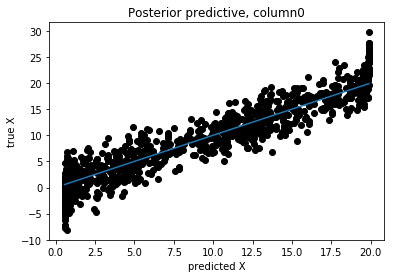

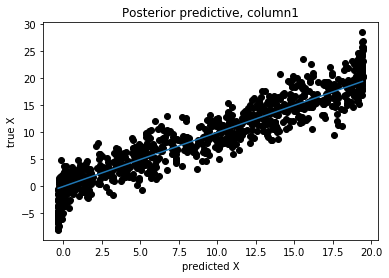

In [17]:
# plot posterior predictive
e_z = newton_results.vb_params['local']['e_z'].get()
mu = newton_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [18]:
# compare CAVI with Newton_tr
print(cavi_results.vb_params['global']['mu'].get())
print(newton_results.vb_params['global']['mu'].get())

print('l1 difference (normalized) between means: ', \
      np.mean(np.abs(cavi_results.vb_params['global']['mu'].get() \
                     - newton_results.vb_params['global']['mu'].get())))

[[  9.86439534   9.71196577]
 [ 10.33477486  10.22472846]
 [  4.823199     5.23114756]
 [  9.86434586   9.71193628]
 [  9.86432575   9.71192429]
 [ 19.88550546  19.44574591]
 [  9.8642763    9.71189483]
 [  0.56729952  -0.34197799]
 [  9.8641864    9.71184131]
 [ 14.25093618  14.71048693]]
[[  9.86426516   9.71168671]
 [ 10.35291437  10.24419656]
 [  4.83129864   5.23833762]
 [  9.8642178    9.71166175]
 [  9.86419854   9.7116516 ]
 [ 19.88837247  19.447678  ]
 [  9.86415118   9.71162666]
 [  0.56839002  -0.33982259]
 [  9.86406495   9.71158126]
 [ 14.26441916  14.72536513]]
l1 difference (normalized) between means:  0.00456450174166


In [19]:
print('l1 difference (normalized) between all params: ', \
      np.mean(np.abs(cavi_results.vb_params.get_free() - newton_results.vb_params.get_free())))

l1 difference (normalized) between all params:  0.00766979444806


# Parametric sensitivity analysis

In particular, we are interested in how posterior quantities depend on our choice of DP parameter $\alpha$. 

As a first step, lets manually perturb $\alpha$ and re-optimize. We will then compare these perturbed results with the sensitivity predicted by LRVB. 

In [20]:
epsilon = 0.1 # how much we will perturb alpha

model_perturbed = deepcopy(newton_results)
model_perturbed.alpha = alpha + epsilon # perturb dp parameter

# define new objective
kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

# find new optima
newton_tr_opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6))

model_perturbed.vb_params['global'].set_free(newton_tr_opt_perturbed.x) 
model_perturbed.set_optimal_z()

Optimization terminated successfully.
         Current function value: -13633.469038
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 0
done :o


In [21]:
# checking the optima

# check that the gradient is close to 0
kl_grad = kl_obj_perturbed.fun_free_grad(newton_tr_opt_perturbed.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj_perturbed.fun_free_hessian(newton_tr_opt_perturbed.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian evals all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

L_inf norm of gradient:  6.70775455343e-10
time to compute Hessian (sec):  8.432334423065186
Hessian evals all positive:  True
distance (l2) to minimizer of quadratic approx. :  2.86315821831e-09


Now, lets do LRVB and get predicted sensitivities for various posterior quantities

### V_stick sensitivity

As a first pass, we look at the sensitivity of the posterior stick lengths to our choice of DP parameter $\alpha$

In [22]:
def get_v_sticks(model, global_free_params): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()

    return model.vb_params['global']['v_sticks'].e()[:,0]

# compute LRVB sensitivity
alpha_sensitivity = lrvb.DPAlphaSensitivity(model, newton_tr_opt.x)
lrvb_sens_v_sticks = alpha_sensitivity.get_param_sensitivity(lambda x : get_v_sticks(model, x))

print('LRVB predicted_sensitivity: \n', lrvb_sens_v_sticks)

# true senstivity
perturbed_mean = model_perturbed.vb_params['global']['v_sticks'].e()[:,0]
old_mean = newton_results.vb_params['global']['v_sticks'].e()[:,0]

print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

evaluating hessian ...
ok
LRVB predicted_sensitivity: 
 [ -1.22303430e-06  -4.16578770e-03  -3.47905457e-03  -2.63257857e-05
  -2.62492304e-05  -3.52642388e-03  -6.01364068e-05  -1.16676355e-02
  -3.37466764e-04]
true sensitivity: 
 [ -1.21466995e-06  -4.13231183e-03  -3.45593150e-03  -2.61152062e-05
  -2.60397775e-05  -3.48549057e-03  -5.95515085e-05  -1.15457173e-02
  -3.33215157e-04]


### Cluster mean sensitivity

We can also check the sensitivity of posterior means to $\alpha$. 

In [23]:
def get_cluster_means(model, global_free_params): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()
    
    return model.vb_params['global']['mu'].get_vector()

# compute LRVB sensitivity
lrvb_sens_means = alpha_sensitivity.get_param_sensitivity(lambda x : get_cluster_means(model, x))

print('LRVB predicted_sensitivity: \n', lrvb_sens_means)

# true senstivity
perturbed_mean = model_perturbed.vb_params['global']['mu'].get_vector()
old_mean = newton_results.vb_params['global']['mu'].get_vector()

print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

LRVB predicted_sensitivity: 
 [ 0.00024365  0.00095363 -0.14350009 -0.14678336 -0.05631429 -0.05087753
  0.00023999  0.00093854  0.00023857  0.00093244  0.00103222  0.0069513
  0.00023524  0.00091751 -0.00709473 -0.01396514  0.00023074  0.00089116
 -0.06658194 -0.08939374]
true sensitivity: 
 [ 0.0002121   0.0009153  -0.14237827 -0.14573348 -0.0557693  -0.05033534
  0.00020896  0.00090082  0.00020775  0.00089498  0.00092433  0.00677171
  0.00020492  0.00088068 -0.0069904  -0.01379816  0.00020135  0.00085551
 -0.06627395 -0.0886815 ]


### Co-clustering sensitivity

Since this is a clustering problem, we can check other moments too: like co-clustering. In particular, for two data points indexed by $n_1$ and $n_2$, we can check the sensitivty of $E[z_{n_1} \cdot z_{n_2}]$, the indicator that $x_{n_1}$ and $x_{n_2}$ belong to the same cluster.

In [24]:
def get_co_clustering(model, global_free_params, n1, n2): 
    model.vb_params['global'].set_free(global_free_params)  
    model.set_optimal_z()

    e_z1 = model.vb_params['local']['e_z'].get()[n1, :]
    e_z2 = model.vb_params['local']['e_z'].get()[n2, :]
    
    return np.dot(e_z1, e_z2)

cluster of first data point:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster of second data point:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster mean of first data point:  [ 10.33477486  10.22472846]
cluster mean of first data point:  [ 10.33477486  10.22472846]

here, black are data points. red are the true means. 
blue are the posterior means. green are the chosen data points. 


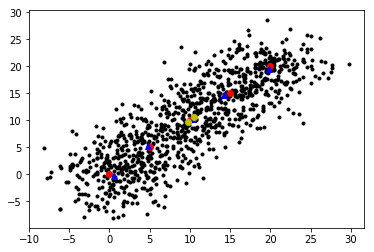

In [25]:
# choose two data points
n1 = 0
n2 = 1

cluster1 = np.round(model.vb_params['local']['e_z'].get()[n1, :])
cluster2 = np.round(model.vb_params['local']['e_z'].get()[n2, :])

print('cluster of first data point: ', cluster1)
print('cluster of second data point: ', cluster2)
print('cluster mean of first data point: ', np.dot(cluster1, cavi_results.vb_params['global']['mu'].get()))
print('cluster mean of first data point: ', np.dot(cluster2, cavi_results.vb_params['global']['mu'].get()))

# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    
plt.plot(x[n1, 0], x[n1, 0], 'yo')
plt.plot(x[n2, 0], x[n2, 0], 'yo')

print('\nhere, black are data points. red are the true means. ')
print('blue are the posterior means. green are the chosen data points. ')

In [26]:
lrvb_sens_co_cluster = alpha_sensitivity.get_param_sensitivity(\
                                        lambda x: get_co_clustering(model, x, n1, n2))

print('predicted_sensitivity: \n', lrvb_sens_co_cluster)
co_clustering = np.dot(newton_results.vb_params['local']['e_z'].get()[n1, :], \
    newton_results.vb_params['local']['e_z'].get()[n2, :])
    
co_clustering_pert = np.dot(model_perturbed.vb_params['local']['e_z'].get()[n1, :], \
    model_perturbed.vb_params['local']['e_z'].get()[n2, :])

print('true_sensitivty: \n', (co_clustering_pert - co_clustering)/ epsilon)


predicted_sensitivity: 
 0.00209594956551
true_sensitivty: 
 0.00197116691136


cluster of first data point:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster of second data point:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
cluster mean of first data point:  [ 10.33477486  10.22472846]
cluster mean of first data point:  [ 0.56729952 -0.34197799]

here, black are data points. red are the true means. 
blue are the posterior means. green are the chosen data points. 


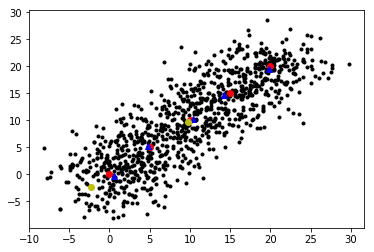

In [27]:
# choose two data points
n1 = 0
n2 = 2

cluster1 = np.round(model.vb_params['local']['e_z'].get()[n1, :])
cluster2 = np.round(model.vb_params['local']['e_z'].get()[n2, :])

print('cluster of first data point: ', cluster1)
print('cluster of second data point: ', cluster2)
print('cluster mean of first data point: ', np.dot(cluster1, cavi_results.vb_params['global']['mu'].get()))
print('cluster mean of first data point: ', np.dot(cluster2, cavi_results.vb_params['global']['mu'].get()))

# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    
plt.plot(x[n1, 0], x[n1, 0], 'yo')
plt.plot(x[n2, 0], x[n2, 0], 'yo')

print('\nhere, black are data points. red are the true means. ')
print('blue are the posterior means. green are the chosen data points. ')


In [28]:
lrvb_sens_co_cluster = alpha_sensitivity.get_param_sensitivity(\
                                        lambda x: get_co_clustering(model, x, n1, n2))

print('predicted_sensitivity: \n', lrvb_sens_co_cluster)

co_clustering = np.dot(newton_results.vb_params['local']['e_z'].get()[n1, :], \
    newton_results.vb_params['local']['e_z'].get()[n2, :])
    
co_clustering_pert = np.dot(model_perturbed.vb_params['local']['e_z'].get()[n1, :], \
    model_perturbed.vb_params['local']['e_z'].get()[n2, :])

print('true_sensitivty: \n', (co_clustering_pert - co_clustering)/ epsilon)

predicted_sensitivity: 
 -8.6263043134e-06
true_sensitivty: 
 -8.47003351392e-06


so we see that the co-clustering of two data points which are close is more sensitive to alpha than two data points that are far away

## Let us check the linearity of the perturbation in alpha

In [29]:
epsilons = np.arange(-2.0, 2.2, 0.2) # the range for which we will perturb alpha

results = np.zeros((len(epsilons), model.vb_params.free_size()))

for i in range(len(epsilons)): 
    print(epsilons[i])
    model_perturbed = deepcopy(newton_results)
    model_perturbed.alpha  = alpha + epsilons[i] # perturb dp parameter

    # define new objective
    kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

    # find new optima
    opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6), disp = False)
    
    # set to optima
    model_perturbed.vb_params['global'].set_free(opt_perturbed.x) 
    model_perturbed.set_optimal_z()
    
    results[i, :] = model_perturbed.vb_params.get_free()    

-2.0
done :o
-1.8
done :o
-1.6
done :o
-1.4
done :o
-1.2
done :o
-1.0
done :o
-0.8
done :o
-0.6
done :o
-0.4
done :o
-0.2
done :o
-4.4408920985e-16
done :o
0.2
done :o
0.4
done :o
0.6
done :o
0.8
done :o
1.0
done :o
1.2
done :o
1.4
done :o
1.6
done :o
1.8
done :o
2.0
done :o


In [30]:
k_stick = 1

perturbed_v_sticks = np.zeros(len(epsilons))
perturbed_co_clusters = np.zeros(len(epsilons))

for i in range(len(epsilons)): 
    model.vb_params.set_free(results[i,:])
    perturbed_v_sticks[i] = model.vb_params['global']['v_sticks'].e()[k_stick, 0]
    
    perturbed_co_clusters[i] = np.dot(model.vb_params['local']['e_z'].get()[n1, :], \
                                model.vb_params['local']['e_z'].get()[n2, :])


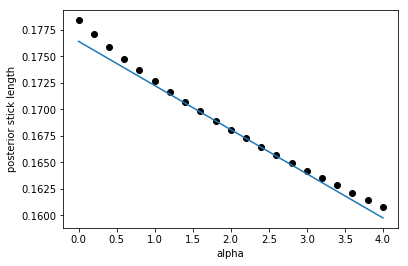

In [31]:
plt.plot(alpha + epsilons, perturbed_v_sticks, 'ko')
# plot the LRVB approximation
x_axis = np.linspace(alpha + epsilons[0], alpha + epsilons[-1], 100)

old_mean = newton_results.vb_params['global']['v_sticks'].e()[k_stick, 0]
plt.plot(x_axis, lrvb_sens_v_sticks[k_stick] * (x_axis - alpha) + old_mean)
plt.xlabel('alpha')
plt.ylabel('posterior stick length')

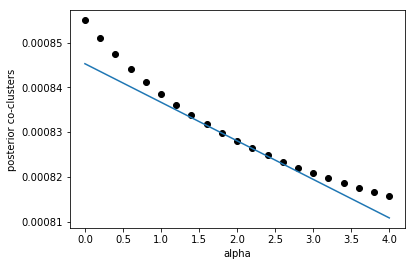

In [32]:
plt.plot(alpha + epsilons, perturbed_co_clusters, 'ko')

# plot the LRVB approximation
x_axis = np.linspace(alpha + epsilons[0], alpha + epsilons[-1], 100)

old_co_cluster = np.dot(newton_results.vb_params['local']['e_z'].get()[n1, :], \
                                newton_results.vb_params['local']['e_z'].get()[n2, :])
plt.plot(x_axis, lrvb_sens_co_cluster * (x_axis - alpha) + old_co_cluster)
plt.xlabel('alpha')
plt.ylabel('posterior co-clusters')